# **OFA**
Start to enjoy open-domain VQA with OFA! 

In [1]:
# clone OFA if there does not exist the repo
% cd /content
! git clone https://github.com/OFA-Sys/OFA.git

/content
Cloning into 'OFA'...
remote: Enumerating objects: 6022, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 6022 (delta 20), reused 36 (delta 11), pack-reused 5960
Receiving objects: 100% (6022/6022), 122.04 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (2309/2309), done.


## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace. We also provide an alternative below. Choose one as you like!

In [2]:
% cd /content
! mkdir -p /content/OFA/checkpoints/
! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_384.pt
! mv ofa_large_384.pt OFA/checkpoints/ofa_large_384.pt

/content
--2022-08-07 20:46:08--  https://ofa-silicon.oss-us-west-1.aliyuncs.com/checkpoints/ofa_large_384.pt
Resolving ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)... 47.88.111.45
Connecting to ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)|47.88.111.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6230622025 (5.8G) [application/octet-stream]
Saving to: ‘ofa_large_384.pt’

ofa_large_384.pt    100%[===================>]   5.80G  15.9MB/s    in 7m 18s  

2022-08-07 20:53:26 (13.6 MB/s) - ‘ofa_large_384.pt’ saved [6230622025/6230622025]



## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

In [3]:
# clone Fairseq for installation
% cd /content
! git clone https://github.com/pytorch/fairseq.git
% cd /content/fairseq
! pip install --use-feature=in-tree-build ./

/content
Cloning into 'fairseq'...
remote: Enumerating objects: 32167, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 32167 (delta 11), reused 9 (delta 4), pack-reused 32129
Receiving objects: 100% (32167/32167), 22.53 MiB | 29.58 MiB/s, done.
Resolving deltas: 100% (23557/23557), done.
/content/fairseq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 116 kB 5.1 MB/s 
     |████████████████████████████████| 235 kB 33.3 MB/s 
     |████████████████████████████████| 123 kB 70.6 MB/s 
     |████████████████████████████████| 112 kB 75.8 MB/s 
     |████████████████████████████████| 596 kB 66.3 MB/s 
  Created wheel for fairseq: filename=fair

In [ ]:
ls /content/OFA/

checkpoints/    evaluate.py  README_EncouragingLoss.md  trainer.py
checkpoints.md  examples/    README.md                  train.py
colab.md        fairseq/     requirements.txt           transformers.md
criterions/     LICENSE      run_scripts/               utils/
data/           models/      spaces.md
datasets.md     ofa_module/  tasks/


## **Preparation**
Below you just need to import required packages, specify some generation options and check whether to use GPU or FP16. 

In [4]:
%cd /content/OFA
! sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=f524a2c5d1132924fb7673ddcd325e72b35823dd214a80a5ee221ecb1f976092
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 124 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, 

In [6]:
import torch
import numpy as np
import re
from fairseq import utils,tasks
from fairseq import checkpoint_utils
from fairseq import distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from utils.zero_shot_utils import zero_shot_step
from tasks.mm_tasks.vqa_gen import VqaGenTask
from models.ofa import OFAModel
from PIL import Image

# Register VQA task
tasks.register_task('vqa_gen',VqaGenTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

# specify some options for evaluation
parser = options.get_generation_parser()
input_args = ["", "--task=vqa_gen", "--beam=100", "--unnormalized", "--path=checkpoints/ofa_large_384.pt", "--bpe-dir=utils/BPE"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [7]:
# Load pretrained ckpt & config
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

2022-08-07 20:56:54 | INFO | tasks.ofa_task | source dictionary: 59457 types
2022-08-07 20:56:54 | INFO | tasks.ofa_task | target dictionary: 59457 types
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [8]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()

# Normalize the question
def pre_question(question, max_ques_words):
    question = question.lower().lstrip(",.!?*#:;~").replace('-', ' ').replace('/', ' ')
    question = re.sub(
        r"\s{2,}",
        ' ',
        question,
    )
    question = question.rstrip('\n')
    question = question.strip(' ')
    # truncate question
    question_words = question.split(' ')
    if len(question_words) > max_ques_words:
        question = ' '.join(question_words[:max_ques_words])
    return question

def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for open-domain VQA task
def construct_sample(image: Image, question: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    question = pre_question(question, task.cfg.max_src_length)
    question = question + '?' if not question.endswith('?') else question
    src_text = encode_text(' {}'.format(question), append_bos=True, append_eos=True).unsqueeze(0)

    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    ref_dict = np.array([{'yes': 1.0}]) # just placeholder
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "ref_dict": ref_dict,
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


## **Run Inference**
Download an image and run the following scripts to generate the predicted answer. Below we provide the samples shown in our paper as well as several other samples. You can also use your own images and have a try!

In [ ]:
ls

checkpoints/    evaluate.py  README_EncouragingLoss.md  trainer.py
checkpoints.md  examples/    README.md                  train.py
colab.md        fairseq/     requirements.txt           transformers.md
criterions/     LICENSE      run_scripts/               utils/
data/           models/      spaces.md
datasets.md     ofa_module/  tasks/


In [28]:
# reproduce the VQA cases provided in our paper (you can use other images with wget)
# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/money_plant.png -O test.png
# image = Image.open('./test.png')
# question = "what is grown on the plant?"
# question = "are there three bills?"

! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/airship.jpg -O test.jpg
image = Image.open('./test.jpg')
# question = "what does the red-roofed building right to the big airship look like?"
question = "Is there more than four mushroom?"

! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/cat.jpg -O test.jpg
image = Image.open('./test.jpg')
question = "where are the cats?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/starry_night.jpeg -O test.jpeg
# image = Image.open('./test.jpeg')
# question = "whose style does the picture belong to?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/light_bulb.png -O test.png
# image = Image.open('./test.png')
# question = "what is the man sitting on?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/bathing_dog.jpg -O test.jpg
# image = Image.open('./test.jpg')
# question = "what is the dog doing now?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/hold_laptop.png -O test.png
# image = Image.open('./test.png')
# question = "what is the person in the right-bottom corner holding now?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/children_stick_figure.png -O test.png
# image = Image.open('./test.png')
# question = "what is the mood of the children in the picture?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/man_stick_figure.png -O test.png
# image = Image.open('./test.png')
# question = "what is the man doing?"

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/solar_system.jpg -O test.jpg
# image = Image.open('./test.jpg')
# question = "what is the name of the largest planet in the picture?"

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image, question)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

--2022-08-07 21:07:38--  https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/airship.jpg
Resolving ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)... 47.88.111.45
Connecting to ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)|47.88.111.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420437 (411K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 410.58K  1.68MB/s    in 0.2s    

2022-08-07 21:07:38 (1.68 MB/s) - ‘test.jpg’ saved [420437/420437]

--2022-08-07 21:07:39--  https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/cat.jpg
Resolving ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)... 47.88.111.45
Connecting to ofa-silicon.oss-us-west-1.aliyuncs.com (ofa-silicon.oss-us-west-1.aliyuncs.com)|47.88.111.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31751

In [29]:
# Run eval step for open-domain VQA
with torch.no_grad():
    result, scores = zero_shot_step(task, generator, models, sample)

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


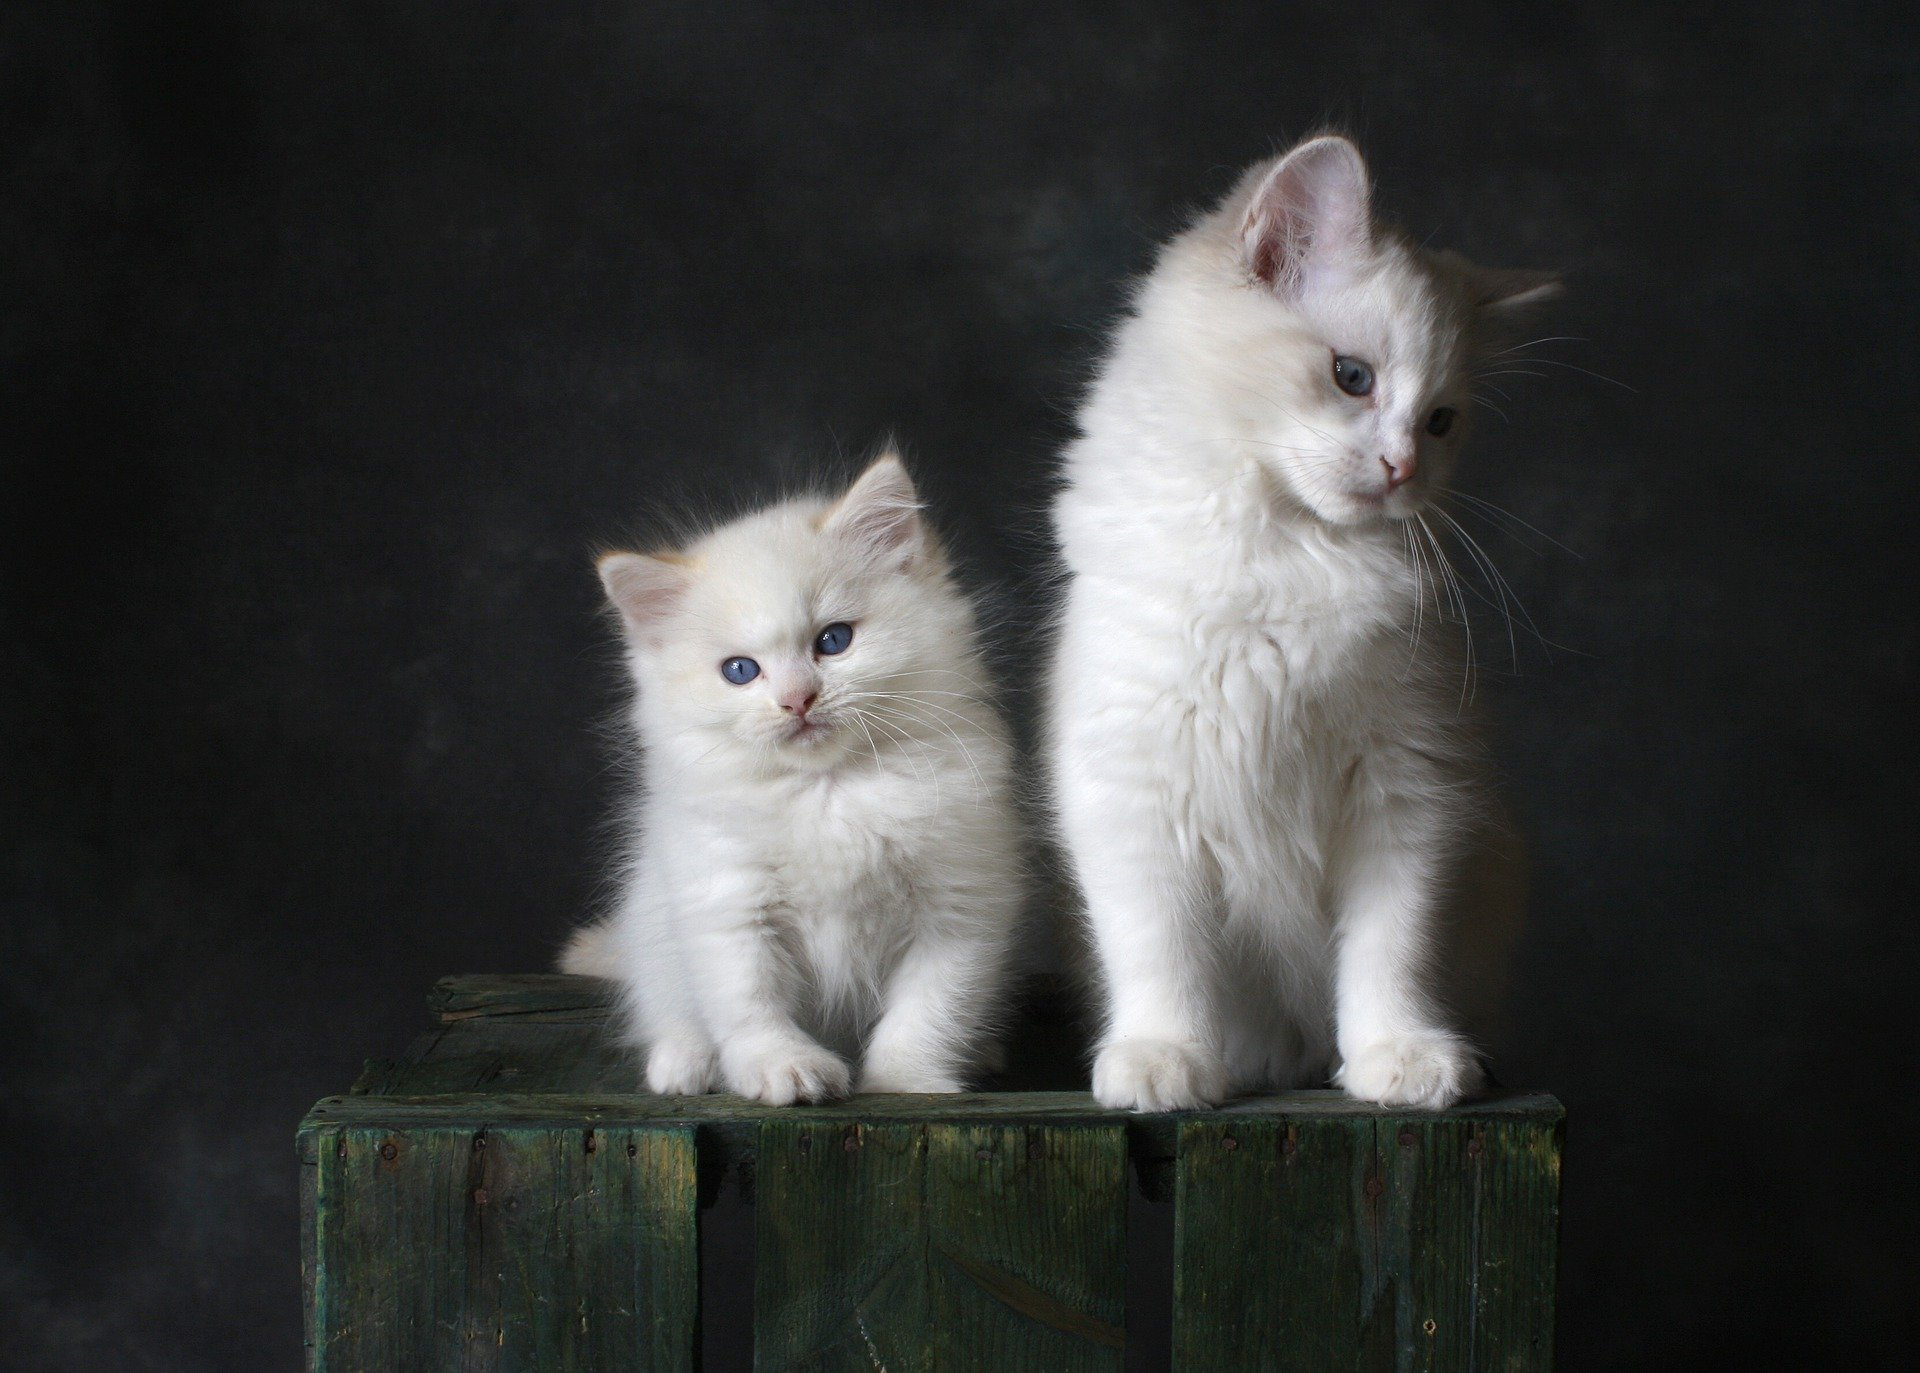

Question: where are the cats?
OFA's Answer: on a piece of wood


In [30]:
display(image)
print('Question: {}'.format(question))
print('OFA\'s Answer: {}'.format(result[0]['answer']))

In [31]:
result

[{'answer': 'on a piece of wood', 'question_id': '42'}]

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ls

checkpoints/    evaluate.py  README_EncouragingLoss.md  test.jpg
checkpoints.md  examples/    README.md                  trainer.py
colab.md        fairseq/     requirements.txt           train.py
criterions/     LICENSE      run_scripts/               transformers.md
data/           models/      spaces.md                  utils/
datasets.md     ofa_module/  tasks/


In [14]:
!unzip /content/drive/MyDrive/VQA/images.zip

Archive:  /content/drive/MyDrive/VQA/images.zip
   creating: images/
  inflating: images/0804.jpeg        
  inflating: __MACOSX/images/._0804.jpeg  
  inflating: images/0107.jpeg        
  inflating: __MACOSX/images/._0107.jpeg  
  inflating: images/0557.jpeg        
  inflating: __MACOSX/images/._0557.jpeg  
  inflating: images/0042.jpeg        
  inflating: __MACOSX/images/._0042.jpeg  
  inflating: images/0412.jpeg        
  inflating: __MACOSX/images/._0412.jpeg  
  inflating: images/0941.jpeg        
  inflating: __MACOSX/images/._0941.jpeg  
  inflating: images/0691.jpeg        
  inflating: __MACOSX/images/._0691.jpeg  
  inflating: images/0384.jpeg        
  inflating: __MACOSX/images/._0384.jpeg  
  inflating: images/0500.jpeg        
  inflating: __MACOSX/images/._0500.jpeg  
  inflating: images/0150.jpeg        
  inflating: __MACOSX/images/._0150.jpeg  
  inflating: images/0853.jpeg        
  inflating: __MACOSX/images/._0853.jpeg  
  inflating: images/0916.jpeg        
  

In [15]:
ls images | wc -l

1024


In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
data = pd.read_csv('/content/drive/MyDrive/VQA/questions.csv', header=None)

QA_Data = {}
for img in range(len(data)):
    QA_Data[img] = {}
    for i, QA in enumerate(data.iloc[img][1:]):
        if not pd.isna(QA):
            Q, A = QA.split('?')
            QA_Data[img][i] = (Q, A.strip())

In [ ]:
pwd

In [19]:
# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/airship.jpg -O test.jpg



# image = Image.open('./images/0001.jpeg')
# question = "what does the red-roofed building right to the big airship look like?"
# question = "Are there more than four mushroom?"

hits = 0
num_qs = 0

with torch.no_grad():
  for i in range(10):#len(QA_Data)):
    print(i)
    image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')
    
    for qdx in QA_Data[i]:
        question, answer = QA_Data[i][qdx][0], QA_Data[i][qdx][1]

        try:
          sample = construct_sample(image, question)
          sample = utils.move_to_cuda(sample) if use_cuda else sample
          sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

          # Run eval step for open-domain VQA
          result, scores = zero_shot_step(task, generator, models, sample)
          QA_Data[i][qdx] = (question, answer.lower(), result[0]['answer'])

          hits += (1 if answer.lower() == result[0]['answer'] else 0)
          print(question,result)
          num_qs += 1 

        except:
          print(f'{i} failed')


print(f'acc= {hits/num_qs}')


0


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


Is there an umbrella in the scene [{'question_id': '42', 'answer': 'yes'}]
Is there a car in the image [{'question_id': '42', 'answer': 'yes'}]
Is there car fully visible [{'question_id': '42', 'answer': 'no'}]
Is the car covered by snow [{'question_id': '42', 'answer': 'yes'}]
Is it daytime [{'question_id': '42', 'answer': 'yes'}]
Is there a person in the image [{'question_id': '42', 'answer': 'no'}]
1
Are there two people wearing caps in the image [{'question_id': '42', 'answer': 'yes'}]
Does anyone have eyeglasses [{'question_id': '42', 'answer': 'yes'}]
Are there two people standing in the image [{'question_id': '42', 'answer': 'yes'}]
Are there balloons at the back of the room [{'question_id': '42', 'answer': 'yes'}]
Is the leftmost person sitting [{'question_id': '42', 'answer': 'yes'}]
Are there any scissors in the scene [{'question_id': '42', 'answer': 'yes'}]
Is it nighttime [{'question_id': '42', 'answer': 'no'}]
Are there cabinets [{'question_id': '42', 'answer': 'yes'}]
Are

In [18]:
result

[{'answer': 'yes', 'question_id': '42'}]

In [ ]:
num_qs

7798

In [ ]:
hits/num_qs

0.7252358490566038

In [ ]:
# failed
# 291
# 355

import json
# the json file where the output must be stored
out_file = open("/content/drive/MyDrive/VQA/vqa_results.json", "w")
  
json.dump(QA_Data, out_file) #, indent = 6)
  
out_file.close()


In [ ]:
i = 355
# qdx

image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')
sample = construct_sample(image, question)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

question = 'Is there more than ten objects in the image'
result, scores = zero_shot_step(task, generator, models, sample)
result

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


[{'answer': 'no', 'question_id': '42'}]

In [ ]:
QA_Data[355]

{0: ('Are there more than ten objects in this image', 'Yes'),
 1: ('Is there a text saying "DoubleGames" at the bottom left of the image',
  'no',
  'yes'),
 2: ('Is there a text saying "DoubleGames" at the bottom right of the image',
  'yes',
  'yes'),
 3: ('Is there a spoon in the image', 'yes', 'no'),
 4: ('Is there a clock to the left of the dull', 'no', 'yes'),
 5: ('Is there a chair in the scene', 'no', 'no'),
 6: ('Is there a clock in the drawer', 'yes', 'yes'),
 7: ('Is there a walking cane', 'yes', 'no')}

In [ ]:
QA_Data[291]

{0: ('Are there more than 10 objects in this image', 'Yes'),
 1: ('Is there a door', 'yes', 'yes'),
 2: ('Is there only one book', 'no', 'no'),
 3: ('Is there a dictionary', 'yes', 'no'),
 4: ('Is there a whiteboard', 'yes', 'yes'),
 5: ('Is there a chair', 'yes', 'yes'),
 6: ('Is there an umbrella', 'no', 'no'),
 7: ('Is there a calculator', 'yes', 'no'),
 8: ('Is there a pen', 'yes', 'yes')}

In [ ]:
QA_Data[355][0] = ('Is there more than ten objects in this image', 'Yes', 'no')
QA_Data[291][0] = ('Is there more than ten objects in this image', 'Yes', 'no')

In [ ]:
!mv ./images/0269.png ./images/0269.jpeg

In [ ]:
hits = 0
num_qs = 0

for i in range(len(QA_Data)):  
  for qdx in QA_Data[i]:
      question, answer, pred = QA_Data[i][qdx]

      hits += (1 if answer.lower() == pred.lower() else 0)
      num_qs += 1 

print(f'acc= {hits/num_qs}')



acc= 0.7508974358974358


# Analysis of typoes

In [ ]:
# import random

def suffle_word(question, num_swaps):
  mm = question.split()
  words_4_Idxs = [a for a,x in enumerate(mm) if len(x) > 3]

  if len(words_4_Idxs) < 1: # just return the question is there no choice
    return question

  # word = random.choice(qq)

  random.shuffle(words_4_Idxs)
  for n in range(min(num_swaps, len(words_4_Idxs))):
    chosen_word_idx = words_4_Idxs[n] #random.choice(words_4_Idxs) 
    chosen_word = mm[chosen_word_idx]


    word = list(chosen_word)
    widx = [h for h in range(1,len(word)-1)]
    random.shuffle(widx)
    idx1, idx2 = widx[:2]
    word[idx1], word[idx2] = word[idx2], word[idx1]
    word = ''.join(word)

    mm[chosen_word_idx] = word 

  return " ".join(mm)


def remove_the(question):
  mm = question.split()
  mm = [w for w in mm if w.lower() not in ['the', 'a', 'an']]

  return " ".join(mm)


# def swap_words(question):
#   mm = question.split()
#   mm = [w for w in mm if w.lower() != 'the']

#   return " ".join(mm)



In [ ]:
# randomly swap two characters

# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/airship.jpg -O test.jpg


import random

image = Image.open('./images/0001.jpeg')
# question = "what does the red-roofed building right to the big airship look like?"
# question = "Are there more than four mushroom?"

num_qs = 0
hits, hits_swap, hits_no_the = 0, 0, 0

numq_thresh = 1000

with torch.no_grad():
  for i in range(len(QA_Data)):
    # print(i)
    image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')
    
    for qdx in QA_Data[i]:
        question, answer = QA_Data[i][qdx][0], QA_Data[i][qdx][1]

        # pick a random work
        # pick two characters inside this word and swap them 

        # question_swap = suffle_word(question, 4)
        question_no_the = remove_the(question)


        try:
          # sample = construct_sample(image, question)
          # sample = utils.move_to_cuda(sample) if use_cuda else sample
          # sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
          # result, scores = zero_shot_step(task, generator, models, sample)
          # hits += (1 if answer.lower() == result[0]['answer'] else 0)


          # sample = construct_sample(image, question_swap)
          # sample = utils.move_to_cuda(sample) if use_cuda else sample
          # sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
          # result, scores = zero_shot_step(task, generator, models, sample)
          # hits_swap += (1 if answer.lower() == result[0]['answer'] else 0)


          sample = construct_sample(image, question_no_the)
          sample = utils.move_to_cuda(sample) if use_cuda else sample
          sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
          result, scores = zero_shot_step(task, generator, models, sample)
          hits_no_the += (1 if answer.lower() == result[0]['answer'] else 0)


          num_qs += 1 
          print(f'{num_qs}: {question}')
          if num_qs > numq_thresh:
            break

        except:
          print(f'{i} failed')

    if num_qs > numq_thresh:
      break

print(num_qs)
print(f'acc= {hits/num_qs}')
print(f'acc= {hits_swap/num_qs}')
print(f'acc= {hits_no_the/num_qs}')


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


1: Is there an umbrella in the scene
2: Is there a car in the image
3: Is there car fully visible
4: Is the car covered by snow
5: Is it daytime
6: Is there a person in the image
7: Are there two people wearing caps in the image
8: Does anyone have eyeglasses
9: Are there two people standing in the image
10: Are there balloons at the back of the room
11: Is the leftmost person sitting
12: Are there any scissors in the scene
13: Is it nighttime
14: Are there cabinets
15: Are three people sitting
16: Is anyone's hands in his pockets
17: Is the license plate on the left side of the table
18: Is there a manikin in the image
19: Does the text on the top right say "Create"
20: Are there more than three glasses on the table
21: Is it daytime
22: Is the table cluttered
23: Is this piece of a newspaper
24: Are there six slices of bread
25: Is the toaster black
26: Does the title of the article say "WHEN WORLDS COLLIDE"
27: Are there any trees in the scene
28: Is there a person in the image
29: 

In [ ]:
i

71

In [ ]:
question_no_the

'Is person on right holding a spatula'

In [ ]:
question

'Is the TV on'

In [ ]:
words_4_Idxs

[1, 2, 3, 4, 5]

In [ ]:
mm

['Is', 'there', 'more', 'than', 'four', 'mushroom?']

In [ ]:
qq

['there', 'more', 'than', 'four', 'mushroom?']

In [ ]:
# print(f'acc= {hits/num_qs}')
# print(f'acc= {hits_swap/num_qs}')
print(f'acc= {hits_no_the/num_qs}')


NameError: ignored

# Effect of not


In [ ]:
# ! wget https://ofa-silicon.oss-us-west-1.aliyuncs.com/assets/open_domain_vqa_colab/airship.jpg -O test.jpg



# image = Image.open('./images/0001.jpeg')
# question = "what does the red-roofed building right to the big airship look like?"
# question = "Are there more than four mushroom?"

hits = 0
num_qs = 0
mismatch = 0

with torch.no_grad():
  for i in range(5): #len(QA_Data)):
    print(i)
    image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')
    
    for qdx in QA_Data[i]:
        question, answer = QA_Data[i][qdx][0], QA_Data[i][qdx][1]
        if not question.startswith('Is there'): continue

        questionNot = 'Is there not' + question[8:] 
        print(question, questionNot)

        try:
          sample = construct_sample(image, question)
          sample = utils.move_to_cuda(sample) if use_cuda else sample
          sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
          result1, scores = zero_shot_step(task, generator, models, sample)

          print(scores)

          sample = construct_sample(image, questionNot)
          sample = utils.move_to_cuda(sample) if use_cuda else sample
          sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
          result2, scores = zero_shot_step(task, generator, models, sample)


          mismatch += (1 if result1[0]['answer'] != result2[0]['answer'] else 0) 

          num_qs += 1 

        except:
          print(f'{i} failed')


print(f'acc= {hits/num_qs}')


0
Is there an umbrella in the scene Is there not an umbrella in the scene


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


[1.0]
Is there a car in the image Is there not a car in the image
[1.0]
Is there car fully visible Is there not car fully visible
[0]
Is there a person in the image Is there not a person in the image
[0]
1
2
Is there a manikin in the image Is there not a manikin in the image
[0]
3
4
Is there a person in the image Is there not a person in the image
[0]
Is there a black toaster in the image Is there not a black toaster in the image
[0]
Is there a white toaster in the image Is there not a white toaster in the image
[1.0]
acc= 0.0


In [ ]:
mismatch

1103

In [ ]:
num_qs

1841

In [ ]:
(1841 - 1103) 

738

In [ ]:
question

'Is anyone holding his glass in the right hand'

In [ ]:
questionNot

'Is there not smoke'

In [ ]:
result

[{'answer': 'no', 'question_id': '42'}]

In [ ]:
task.__dict__

{'ans2label_dict': {'no': 0, 'yes': 1},
 'bpe': <fairseq.data.encoders.gpt2_bpe.GPT2BPE at 0x7f3e8676ae50>,
 'cfg': {'_name': 'vqa_gen', 'data': '', 'selected_cols': None, 'bpe_dir': 'utils/BPE', 'max_source_positions': 1024, 'max_target_positions': 1024, 'max_src_length': 128, 'max_tgt_length': 30, 'code_dict_size': 8192, 'patch_image_size': 480, 'num_bins': 1000, 'imagenet_default_mean_and_std': False, 'constraint_range': None, 'max_object_length': 30, 'ans2label_dict': '{"no": 0, "yes":1}', 'ans2label_file': None, 'add_object': False, 'valid_batch_size': 20, 'prompt_type': None, 'uses_ema': False, 'val_inference_type': 'allcand', 'eval_args': '{"beam":5,"unnormalized":true,"temperature":1.0}'},
 'constraint_trie': <utils.trie.Trie at 0x7f3e8676ab10>,
 'dataset_to_epoch_iter': {},
 'datasets': {},
 'index2ans': {0: 'no', 1: 'yes'},
 'src_dict': <fairseq.data.dictionary.Dictionary at 0x7f3e869cda50>,
 'state': <fairseq.tasks.fairseq_task.StatefulContainer at 0x7f3e8610ac50>,
 'tgt_dic

# The effect of masking faces

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
data = pd.read_csv('/content/drive/MyDrive/VQA/questions.csv', header=None)

QA_Data_F = {}
for img in range(len(data)):
    QA_Data_F[img] = {}
    for i, QA in enumerate(data.iloc[img][1:]):
        if not pd.isna(QA):
            Q, A = QA.split('?')
            QA_Data_F[img][i] = (Q, A.strip())


In [ ]:
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [ ]:
pwd

'/content/OFA'

In [ ]:
def maskfaces(img):
    img = cv2.imread(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(gray.shape)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    gray = (211,211,211)

    # faces from Open CV
    if len(faces) <= 0: return (len(faces), img)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), gray) #, thickness)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()


    return (len(faces), img)

In [ ]:
# ls images
!ls

checkpoints	haarcascade_frontalface_default.xml  run_scripts
checkpoints.md	images				     spaces.md
colab.md	LICENSE				     tasks
criterions	__MACOSX			     test.jpg
data		models				     trainer.py
datasets.md	ofa_module			     train.py
evaluate.py	README_EncouragingLoss.md	     transformers.md
examples	README.md			     utils
fairseq		requirements.txt


In [ ]:
!wget https://github.com/kipr/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-05-17 16:25:38--  https://github.com/kipr/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal     [ <=>                ] 127.85K  --.-KB/s    in 0.01s   

2022-05-17 16:25:39 (11.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [130915]



In [ ]:

hits = 0
num_qs = 0

with torch.no_grad():
  for i in range(1,2): #len(QA_Data_F)):
    print(i)
    image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')
    
    image = maskfaces(f'./images/{str(i+1).zfill(4)}.jpeg')

    for qdx in QA_Data_F[i]:
        question, answer = QA_Data_F[i][qdx][0], QA_Data_F[i][qdx][1]

        try:
          sample = construct_sample(image, question)
          sample = utils.move_to_cuda(sample) if use_cuda else sample
          sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

          # Run eval step for open-domain VQA
          result, scores = zero_shot_step(task, generator, models, sample)
          QA_Data_F[i][qdx] = (question, answer.lower(), result[0]['answer'])

          hits += (1 if answer.lower() == result[0]['answer'] else 0)
          # print(result)
          num_qs += 1 

        except:
          print(f'{i} failed')


print(f'acc= {hits/num_qs}')


1
(375, 500, 3)


error: ignored

#Sending in blank images



In [ ]:
hits = 0
num_qs = 0

with torch.no_grad():
  for i in range(len(QA_Data)):
    print(i)
    image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')
    # print(image.size)
    # image = Image.fromarray(np.uint8(np.zeros((image.size[1], image.size[0], 3))))
    
    image = Image.fromarray(np.uint8(numpy.random.random((image.size[1], image.size[0], 3))*255))
    # print(image.size)

#   samples = numpy.random.random(size=num_samples)

    
    for qdx in QA_Data[i]:
        question, answer = QA_Data[i][qdx][0], QA_Data[i][qdx][1]

        try:
          sample = construct_sample(image, question)
          sample = utils.move_to_cuda(sample) if use_cuda else sample
          sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

          # Run eval step for open-domain VQA
          result, scores = zero_shot_step(task, generator, models, sample)
          QA_Data[i][qdx] = (question, answer.lower(), result[0]['answer'])

          hits += (1 if answer.lower() == result[0]['answer'] else 0)
          # print(result)
          num_qs += 1 

        except:
          print(f'{i} failed')


print(f'acc= {hits/num_qs}')


0


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


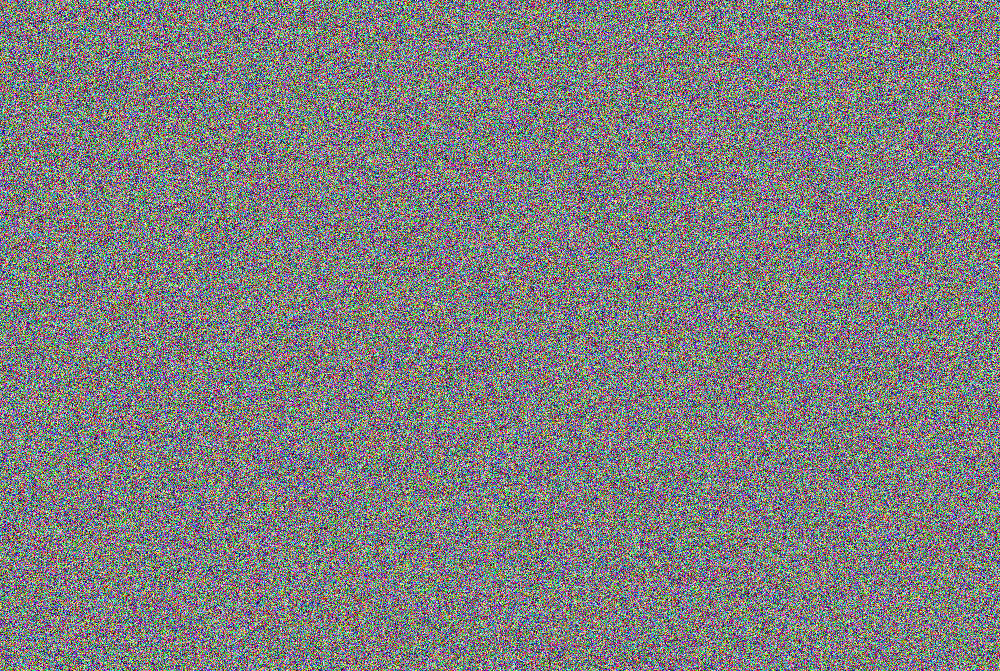

In [ ]:
image

In [ ]:
image = Image.fromarray(np.uint8(np.zeros((100, 200, 3))))
sample = construct_sample(image, question)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
result, scores = zero_shot_step(task, generator, models, sample)

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


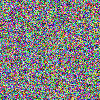

In [ ]:
Image.fromarray(np.uint8(numpy.random.random((100, 100, 3))*255))

In [ ]:
import numpy
np.uint8(numpy.random.random((2,2,2))*255)

array([[[ 13,  10],
        [227, 126]],

       [[220, 211],
        [ 23,  24]]], dtype=uint8)

# Questions for sure the answer is No

In [ ]:
import collections
objects = ['white orange', 'dragon', 'blue horse', 'backgammon board', 'parrot', 'boxer dog', 'ostrich', 'dinosaur egg', 'galaxy', 'mermaid', 'telescope', 
           'unicorn', 'centipede', 'yellow cow', 'yeti']


objects = ['orange', 'apple', 'person', 'horse', 'cow', 'fridge', 'egg', 'cup']

hits = collections.defaultdict(list)

with torch.no_grad():
  for i in range(len(QA_Data)):
    print(i)
    image = Image.open(f'./images/{str(i+1).zfill(4)}.jpeg')

    for obj in objects:      
      question = f'Is there a {obj} in this image?'

      try:
        sample = construct_sample(image, question)
        sample = utils.move_to_cuda(sample) if use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

        # Run eval step for open-domain VQA
        result, scores = zero_shot_step(task, generator, models, sample)

        hits[obj].append(1 if 'no' == result[0]['answer'] else 0)
        # print(result)

      except:
        print(f'{i} failed')


# print(f'acc= {hits/num_qs}')


0


/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


1
2
3
4
5
6
7
8
9
10
11
11 failed
12
12 failed
12 failed
12 failed
12 failed
12 failed
12 failed
12 failed
12 failed
13
13 failed
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [ ]:
hits

NameError: ignored

In [ ]:
for obj in hits:
  print()